In [2]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

In [4]:
sess = tf.Session()
epochs = 20 #整個dataset run 20次
batch_size = 250 #一次250筆資料
max_sequence_length = 25 #一個句子最大25個句子
rnn_size = 10 #rnn size = 10?????
embedding_size = 50 #文字的embedding size 50
min_word_frequency = 10 #選最少出現10次以上的字
learning_rate = 0.0005 
dropout_keep_prob = tf.placeholder(tf.float32) #drop out 的Placeholder

In [10]:
#讀資料與解析資料
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
# Save data to text file
with open(os.path.join(data_dir, data_file), 'w') as file_conn:
    for text in text_data:
        file_conn.write("{}\n".format(text))
    else:
        # Open data from text file
        text_data = []
        with open(os.path.join(data_dir, data_file), 'r') as file_conn:
            for row in file_conn:
                text_data.append(row)
            text_data = text_data[:-1]
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    [text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [14]:
print(text_data_target[0:5])
print(text_data_train[0:5])

['ham', 'ham', 'spam', 'ham', 'ham']
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', 'Ok lar... Joking wif u oni...\n', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n", 'U dun say so early hor... U c already then say...\n', "Nah I don't think he goes to usf, he lives around here though\n"]


In [15]:
#清理文字中的所有特殊符號
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)
# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

In [17]:
print(text_data_train[0:5])

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat', 'ok lar joking wif u oni', 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs', 'u dun say so early hor u c already then say', 'nah i dont think he goes to usf he lives around here though']


In [18]:
#用tensorflow內建的文字處理fn來處理文字
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
    max_sequence_length,min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [22]:
text_processed[0:5]

array([[ 44, 451,   0, 802, 701, 664,  62,   9,   0,  87, 122, 366,   0,
        148,   0,   0,  66,  56,   0, 136,   0,   0,   0,   0,   0],
       [ 46, 313,   0, 454,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 47, 461,   9,   4, 769, 881,   2, 178,   0,   0, 619,   0, 234,
        255,  69,   0,   2,   2, 317, 461,   0,  77,   0, 368,   0],
       [  6, 230, 140,  24, 354,   0,   6, 155, 141,  58, 140,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  42,  99,  70, 462,   2, 925,  70,   0, 200, 110, 468,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

In [23]:
#建立訓練target與打亂次序
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

In [24]:
#拆分成訓練集與測試集
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train),len(y_test)))

Vocabulary Size: 930
80-20 Train Test split: 4433 -- 1109


In [25]:
#建立x, y的placeholder
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

In [26]:
#建立embedding 的data
embedding_mat = tf.Variable(tf.random_uniform([vocab_size,embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [27]:
#初始化Model
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size) #定義RNN模型與size
#建立動態RNN模型????????
output, state = tf.nn.dynamic_rnn(cell, embedding_output,dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob) #在rnn中加入dropout

In [28]:
#取得預測的值
output = tf.transpose(output, [1, 0, 2])
#取得最後一個RNN 預測的文字
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [31]:
#將預測出的RNN結果分類成2個class
weight = tf.Variable(tf.truncated_normal([rnn_size, 2],stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [33]:
#定義loss function與計算loss
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

In [34]:
#計算accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out,1), tf.cast(y_output, tf.int64)), tf.float32))

In [36]:
#建立optimization 的function
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)

C:\Users\AdamChang\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [41]:
#開始訓練模型
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
# Start training
for epoch in range(epochs):
    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy],feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy],
    feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.44, Test Acc: 0.88
Epoch: 2, Test Loss: 0.44, Test Acc: 0.88
Epoch: 3, Test Loss: 0.44, Test Acc: 0.88
Epoch: 4, Test Loss: 0.44, Test Acc: 0.88
Epoch: 5, Test Loss: 0.44, Test Acc: 0.88
Epoch: 6, Test Loss: 0.44, Test Acc: 0.88
Epoch: 7, Test Loss: 0.44, Test Acc: 0.88
Epoch: 8, Test Loss: 0.44, Test Acc: 0.88
Epoch: 9, Test Loss: 0.44, Test Acc: 0.88
Epoch: 10, Test Loss: 0.44, Test Acc: 0.88
Epoch: 11, Test Loss: 0.44, Test Acc: 0.88
Epoch: 12, Test Loss: 0.44, Test Acc: 0.88
Epoch: 13, Test Loss: 0.44, Test Acc: 0.88
Epoch: 14, Test Loss: 0.44, Test Acc: 0.88
Epoch: 15, Test Loss: 0.44, Test Acc: 0.88
Epoch: 16, Test Loss: 0.44, Test Acc: 0.88
Epoch: 17, Test Loss: 0.44, Test Acc: 0.88
Epoch: 18, Test Loss: 0.44, Test Acc: 0.88
Epoch: 19, Test Loss: 0.44, Test Acc: 0.88
Epoch: 20, Test Loss: 0.44, Test Acc: 0.88


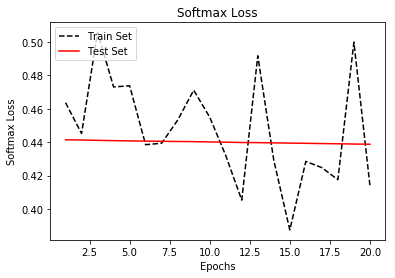

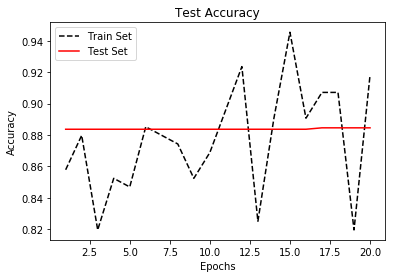

In [42]:
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()
# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()